# Load Model

In [1]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials
from keras.models import Model
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import pickle
import keras
import tensorflow as tf
from keras import backend as K
import sys
import os
import time
sys.path.append(os.path.abspath('../'))
import helpers
from helpers.data_generator import process_data, AutoEncoderDataGenerator, DataGenerator
from helpers.custom_losses import normed_mse, mean_diff_sum_2, max_diff_sum_2, mean_diff2_sum2, max_diff2_sum2

import copy
from helpers.normalization import normalize, denormalize, renormalize
import scipy
from tqdm import tqdm

Using TensorFlow backend.


### Print files

In [2]:
os.chdir(os.path.expanduser('/home/aiqtidar/test_run/'))
files = [foo for foo in os.listdir() if '.pkl' in foo]
files

['model-autoencoder_SET-dense_SDT-dense_CET-dense_CDT-dense_profiles-temp-dens-ffprime_EFIT02-press_EFIT02-q_EFIT02_act-pinj-curr-tinj-gasA_LB-0_LA-3_17Nov20-09-22_Scenario-1_params.pkl',
 'model-autoencoder_SET-dense_SDT-dense_CET-dense_CDT-dense_profiles-temp-dens-ffprime_EFIT02-press_EFIT02-q_EFIT02_act-pinj-curr-tinj-gasA_LB-0_LA-3_17Nov20-09-26_Scenario-1_params.pkl']

# Get Matrices

In [3]:
def get_AB(model):
    A = model.get_layer('AB_matrices').get_weights()[1].T
    B = model.get_layer('AB_matrices').get_weights()[0].T
    return A,B

model = keras.models.load_model('/home/aiqtidar/run_results_11_15/model-autoencoder_SET-dense_SDT-dense_CET-dense_CDT-dense_profiles-temp-dens-ffprime_EFIT02-press_EFIT02-q_EFIT02_act-pinj-curr-tinj-gasA_LB-0_LA-3_16Nov20-16-52_Scenario-0.h5', compile=False)
with open('/home/aiqtidar/run_results_11_15/model-autoencoder_SET-dense_SDT-dense_CET-dense_CDT-dense_profiles-temp-dens-ffprime_EFIT02-press_EFIT02-q_EFIT02_act-pinj-curr-tinj-gasA_LB-0_LA-3_16Nov20-16-52_Scenario-0_params.pkl', 'rb') as f:
    scenario = pickle.load(f, encoding='latin1')
        
A,B = get_AB(model)

W0317 11:05:33.345102 35184372369072 module_wrapper.py:139] From /scratch/gpfs/aiqtidar/.conda/envs/tfgpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0317 11:05:33.372702 35184372369072 module_wrapper.py:139] From /scratch/gpfs/aiqtidar/.conda/envs/tfgpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0317 11:05:33.613503 35184372369072 module_wrapper.py:139] From /scratch/gpfs/aiqtidar/.conda/envs/tfgpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

/scratch/gpfs/aiqtidar/.conda/envs/tfgpu/lib/python3.7/site-packages/keras/engine/saving.py:348: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  war

In [4]:
print("A: " + str(A.shape))
print("B: " + str(B.shape))

A: (20, 20)
B: (20, 5)


# CVXOPT Example

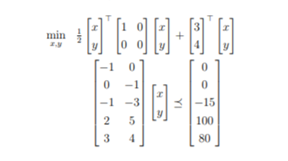

In [5]:
# Import the necessary packages
import numpy
from cvxopt import matrix
from cvxopt import solvers
# Define QP parameters (directly)
P = matrix([[1.0,0.0],[0.0,0.0]])
q = matrix([3.0,4.0])
G = matrix([[-1.0,0.0,-1.0,2.0,3.0],[0.0,-1.0,-3.0,5.0,4.0]])
h = matrix([0.0,0.0,-15.0,100.0,80.0])

# Define QP parameters (with NumPy)
P = matrix(numpy.diag([1,0]), tc='d')
q = matrix(numpy.array([3,4]), tc='d')
G = matrix(numpy.array([[-1,0],[0,-1],[-1,-3],[2,5],[3,4]]), tc='d')
h = matrix(numpy.array([0,0,-15,100,80]), tc='d')

# Construct the QP, invoke solver
sol = solvers.qp(P,q,G,h)

# Extract optimal value and solution
sol['x'] # [7.13e-07, 5.00e+00]
sol['primal objective'] # 20.0000061731




     pcost       dcost       gap    pres   dres
 0:  1.0780e+02 -7.6366e+02  9e+02  0e+00  4e+01
 1:  9.3245e+01  9.7637e+00  8e+01  1e-16  3e+00
 2:  6.7311e+01  3.2553e+01  3e+01  6e-17  1e+00
 3:  2.6071e+01  1.5068e+01  1e+01  8e-17  7e-01
 4:  3.7092e+01  2.3152e+01  1e+01  6e-17  4e-01
 5:  2.5352e+01  1.8652e+01  7e+00  3e-16  4e-16
 6:  2.0062e+01  1.9974e+01  9e-02  6e-17  4e-17
 7:  2.0001e+01  2.0000e+01  9e-04  2e-16  2e-16
 8:  2.0000e+01  2.0000e+01  9e-06  2e-16  1e-16
Optimal solution found.


20.00000617311241

# Minimization

Our problem is as follows:

Minimize:

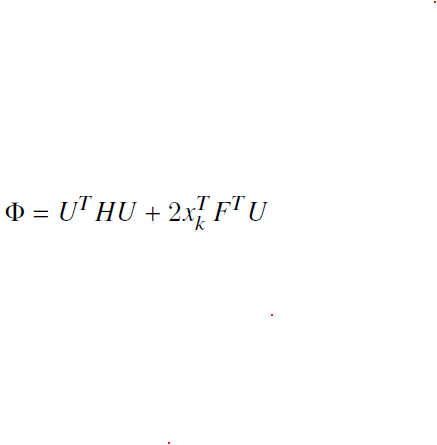

where

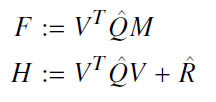

and

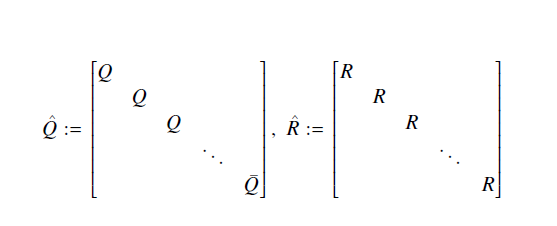


Note:

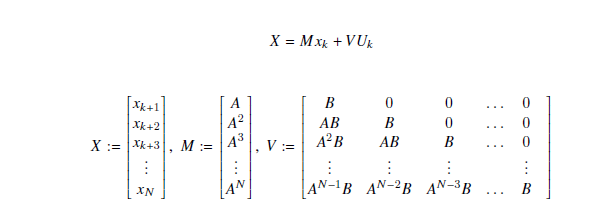

In [6]:
# Import the necessary packages
import numpy
from cvxopt import matrix
from cvxopt import solvers


# Define parameters
N = A.shape[0]
M = B.shape[1]
n = 4 # Number of timesteps

x_0 = np.ones([N,1])*0.5
u_0 = np.ones([M,1])

############################### Generate Matrices ####################################

# Generate X vector
# x_i = A.dot(x_0) + B.dot(u_0)
# X = [x_i]

# for i in range(0,n-1):
#     x_i = A.dot(x_i) + B.dot(u_i)
#     X.append(x_i)
# X = np.array(X)

# Generate Matrix M
M_bar = np.zeros((N * n, N))
rsl = slice(0, N)
M_bar[rsl, :N] = A

for i in range(1, n):
    rsl_p, rsl = rsl, slice(i * N, (i + 1) * N)
    M_bar[rsl, :N] = A @ M_bar[rsl_p, :N]

# print("A: " + str(A))
# print("A^2:" + str(A.dot(A)))
# print("M: " + str(M))

# Generate Q,R
Q = np.eye(N)
R = np.eye(M)

# Generate Q_bar
Q_bar = np.zeros((N * n, N * n))
rsl = slice(0, N)
Q_bar[rsl, :N] = Q

for i in range(1, n):
    rsl_p, rsl = rsl, slice(i * N, (i + 1) * N)
    Q_bar[rsl, N : (i + 1) * N] = Q_bar[rsl_p, : i * N]

# print("Q:" + str(Q))
# print("Q_bar: " + str(Q_bar))

# Generate R_bar
R = np.diag(np.ones((M)))
R_bar = np.kron(np.eye(n),R)

# R_bar = np.zeros((N * n, N * n))
# rsl = slice(0, N)
# R_bar[rsl, :M] = R

# for i in range(1, n):
#     rsl_p, rsl = rsl, slice(i * N, (i + 1) * N)
#     R_bar[rsl, M : (i + 1) * M] = R_bar[rsl_p, : i * M]

# print("R:" + str(R))
# print("R_bar: " + str(R_bar))


# Generate V
V = np.zeros((N * n, n * M))
rsl = slice(0, N)
V[rsl, :M] = B #Make first line

for i in range(1, n):
    rsl_p, rsl = rsl, slice(i * N, (i + 1) * N)
    V[rsl, :M] = A @ V[rsl_p, :M] # A^(N-1)*B
    V[rsl, M : (i + 1) * M] = V[rsl_p, : i * M]

# print("A: " + str(A))
# print("B:" + str(B))
# print("V: " + str(V))

# Generate D_bar, d
# D_bar = np.zeros((M*n,M*n))
# rsl = slice(0,M*n)
# D_bar[rsl, rsl] = np.eye(M*n)
# # D_bar[slice(M*n,2*M*n), rsl] = -np.eye(M*n)

# d = np.zeros((1,M*n))
# d[:,rsl] = np.ones((1,M*n))
# # d[:,slice(M,2*M)] = -np.ones((1,M))

D_bar = np.zeros((2*M*n,M*n))
rsl = slice(0,M*n)
D_bar[rsl, rsl] = np.eye(M*n)
D_bar[slice(M*n,2*M*n), rsl] = -np.eye(M*n)

d = np.zeros((2*M*n,1))
d[rsl,:] = np.ones((M*n,1))*2
d[slice(M*n,2*M*n),:] = -np.ones((M*n,1))

# D_bar = np.zeros((2*M*n,M*n))
# d = np.zeros((2*M*n,1))


# Generate F and H matrices
temp = np.transpose(V).dot(Q_bar)
F = temp.dot(M_bar)

temp = np.transpose(V).dot(Q_bar)
H = temp.dot(V) + R_bar

########################################### Do computations #############################

# Define QP parameters (with NumPy)


P = matrix(H, tc='d')
q = matrix(F.dot(x_0), tc='d')
G = matrix(D_bar, tc='d')
h = matrix(d, tc='d')


######################################### Print Solution ###############################
# Construct the QP, invoke solver
sol = solvers.qp(P,q,G,h)
# Extract optimal value and solution
sol['x'] # [7.13e-07, 5.00e+00]
sol['primal objective'] # 20.0000061731

     pcost       dcost       gap    pres   dres
 0:  9.2162e+00 -1.2543e+01  2e+02  1e+00  1e-15
 1:  2.2098e+01  5.2661e+00  4e+01  2e-01  8e-16
 2:  2.7612e+01  2.4354e+01  3e+00  1e-16  6e-15
 3:  2.6381e+01  2.6251e+01  1e-01  1e-16  8e-16
 4:  2.6329e+01  2.6322e+01  8e-03  9e-17  1e-15
 5:  2.6326e+01  2.6326e+01  4e-04  1e-16  1e-15
 6:  2.6326e+01  2.6326e+01  5e-06  1e-16  1e-15
Optimal solution found.


26.325779798401673

In [7]:
print(sol['x'])

[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.41e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.67e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.09e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]
[ 1.00e+00]



In [26]:
N = 2
n = 3
A = np.ones((N,N))

L = np.zeros((N * n, N * n))
rsl = slice(0, N)
L[rsl, :N] = A #Make first line
    
for i in range(1, n):
    rsl_p, rsl = rsl, slice(i * N, (i + 1) * N)
    L[rsl, :N] = L[rsl_p, :N]
    L[rsl, N : (i + 1) * N] = A @ L[rsl_p, : i * N]

print("A:" + str(A))
print("L: " + str(L))

A:[[1. 1.]
 [1. 1.]]
L: [[1. 1. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0.]
 [1. 1. 2. 2. 0. 0.]
 [1. 1. 2. 2. 0. 0.]
 [1. 1. 2. 2. 4. 4.]
 [1. 1. 2. 2. 4. 4.]]


In [28]:
#Generate X_F from x_f
N = 2
n = 3
xf = np.array([1,2])

X_F = np.zeros((N*n))

for i in range(0,n):
    rsl = slice(i * N, (i + 1)*N)
    X_F[rsl] = xf

print("xf:" + str(xf))
print("X_F:" + str(X_F))

xf:[1 2]
X_F:[1. 2. 1. 2. 1. 2.]


In [9]:
d.shape

(40, 1)

# Control Code Starts here

In [10]:
import pickle
import keras
import tensorflow as tf
from keras import backend as K
import numpy as np
import sys
import os
sys.path.append(os.path.abspath('../'))
from helpers.data_generator import process_data, AutoEncoderDataGenerator
from helpers.custom_losses import denorm_loss, hinge_mse_loss
from helpers.custom_losses import percent_correct_sign, baseline_MAE
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from time import strftime, localtime
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import copy
from tqdm import tqdm_notebook
import seaborn as sns
from helpers.normalization import normalize, denormalize, renormalize
import scipy
from keras.utils.vis_utils import model_to_dot
from IPython.display import Image, display
import gspread
from oauth2client.service_account import ServiceAccountCredentials
from helpers.custom_init import downsample
from helpers.custom_reg import groupLasso
import helpers

# CPU Only. 
os.environ["CUDA_VISIBLE_DEVICES"]="-1"  
num_cores = 1
config = tf.ConfigProto(intra_op_parallelism_threads=4*num_cores,
                        inter_op_parallelism_threads=4*num_cores, 
                        allow_soft_placement=True,
                        device_count = {'CPU' : 1,
                                        'GPU' : 0})
                        
session = tf.Session(config=config)
K.set_session(session)

%matplotlib inline
font={'family': 'DejaVu Serif',
      'size': 18}
plt.rc('font', **font)
matplotlib.rcParams['figure.facecolor'] = (1,1,1,1)

matplotlib_colors = [(0.1215, 0.4667, 0.7058), # blue
                     (1.0000, 0.4980, 0.0549), # orange
                     (0.1725, 0.6275, 0.1725), # green
                     (0.8392, 0.1529, 0.1568), # red
                     (0.5804, 0.4039, 0.7412), # violet
                     (0.4980, 0.4980, 0.4980), # grey
                     (0.0902, 0.7450, 0.8117)] # cyan

matlab_colors=[(0.0000, 0.4470, 0.7410), # blue
               (0.8500, 0.3250, 0.0980), # reddish orange
               (0.9290, 0.6940, 0.1250), # yellow
               (0.4940, 0.1840, 0.5560), # purple
               (0.4660, 0.6740, 0.1880), # light green
               (0.3010, 0.7450, 0.9330), # cyan
               (0.6350, 0.0780, 0.1840)] # dark red

colorblind_colors = [(0.0000, 0.4500, 0.7000), # blue
                     (0.8359, 0.3682, 0.0000), # vermillion
                     (0.0000, 0.6000, 0.5000), # bluish green
                     (0.9500, 0.9000, 0.2500), # yellow
                     (0.3500, 0.7000, 0.9000), # sky blue
                     (0.8000, 0.6000, 0.7000), # reddish purple
                     (0.9000, 0.6000, 0.0000)] # orange

dashes = [(1.0, 0.0, 0.0, 0.0, 0.0, 0.0), # solid
          (3.7, 1.6, 0.0, 0.0, 0.0, 0.0), # dashed
          (1.0, 1.6, 0.0, 0.0, 0.0, 0.0), # dotted
          (6.4, 1.6, 1.0, 1.6, 0.0, 0.0), # dot dash
          (3.0, 1.6, 1.0, 1.6, 1.0, 1.6), # dot dot dash
          (6.0, 4.0, 0.0, 0.0, 0.0, 0.0), # long dash
          (1.0, 1.6, 3.0, 1.6, 3.0, 1.6)] # dash dash dot

from matplotlib import rcParams, cycler
matplotlib.rcdefaults()
rcParams['font.family'] = 'DejaVu Serif'
rcParams['mathtext.fontset'] = 'cm'
rcParams['font.size'] = 12
rcParams['figure.facecolor'] = (1,1,1,1)
rcParams['figure.figsize'] = (16,8)
rcParams['figure.dpi'] = 141
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['axes.labelsize'] =  'large'
rcParams['axes.titlesize'] = 'x-large'
rcParams['lines.linewidth'] = 2.5
rcParams['lines.solid_capstyle'] = 'round'
rcParams['lines.dash_capstyle'] = 'round'
rcParams['lines.dash_joinstyle'] = 'round'
rcParams['xtick.labelsize'] = 'large'
rcParams['ytick.labelsize'] = 'large'
# rcParams['text.usetex']=True
color_cycle = cycler(color=colorblind_colors)
dash_cycle = cycler(dashes=dashes)
rcParams['axes.prop_cycle'] =  color_cycle

labelsize=10
ticksize=8
# for i,c in enumerate(colorblind_colors):
#     plt.plot((i)*np.ones(5),c=c)

eq_sigs = {'temp':'etemp',
         'thomson_temp_EFITRT1':'etemp',
         'thomson_temp_EFITRT2':'etemp',
         'dens':'edens',
         'thomson_dens_EFITRT1':'edens',
         'thomson_dens_EFITRT2':'edens',
         'itemp':'itemp',
         'cerquick_temp_EFITRT1':'itemp',
         'cerquick_temp_EFITRT2':'itemp',
         'rotation':'rotation',
         'cerquick_rotation_EFITRT1':'rotation',
         'cerquick_rotation_EFITRT2':'rotation',
         'press_EFITRT1':'press',
         'press_EFITRT2':'press',
         'press_EFIT01':'press',
         'press_EFIT02':'press',
         'ffprime_EFITRT1':'ffprime',
         'ffprime_EFITRT2':'ffprime',
         'ffprime_EFIT01':'ffprime',
         'ffprime_EFIT02':'ffprime',
         'q':'q',
         'q_EFITRT1':'q',
         'q_EFITRT2':'q',
         'q_EFIT01':'q',
         'q_EFIT02':'q'}

labels = {'edens': '$n_e$ ($10^{19}/m^3$)',
          'etemp': '$T_e$ (keV)',
          'itemp': '$T_i$ (keV)',
          'rotation':'$\Omega$ (kHz)',
          'q':'$\iota$',
          'press':'$P$ (Pa)',
         'ffprime':"$FF'$"}

labels = {key:labels[val] for key, val in eq_sigs.items()}

scatter_titles = {'mean':'Mean',
                  'std':'Std Dev.',
                  'pca_1':'PCA Mode 1',
                  'pca_2':'PCA Mode 2',
                  'pca_3':'PCA Mode 3',
                  'pca_4':'PCA Mode 4',
                  'pca_5':'PCA Mode 5',
                  'pca_6':'PCA Mode 6',
                  'pca_2':'PCA Mode 2'}


datapath = '/scratch/gpfs/jabbate/full_data_with_error/train_data.pkl'
with open(datapath,'rb') as f:
    rawdata = pickle.load(f,encoding='latin1')
    
traindata, valdata, normalization_dict = process_data(rawdata,
                                                              scenario['sig_names'],
                                                              scenario['normalization_method'],
                                                              scenario['window_length'],
                                                              scenario['window_overlap'],
                                                              scenario['lookback'],
                                                              scenario['lookahead'],
                                                              scenario['sample_step'],
                                                              scenario['uniform_normalization'],
                                                              1,
                                                              0,
                                                              scenario['nshots'],
                                                              2,
                                                              scenario['flattop_only'],
                                                              pruning_functions=scenario['pruning_functions'],
                                                              invert_q = None, #scenario['invert_q'],
                                                              val_idx = 0,
                                                              excluded_shots=scenario['excluded_shots'],
                                                            randomize=False)
valdata = denormalize(valdata, normalization_dict)
valdata = renormalize(valdata, scenario['normalization_dict'])
generator = AutoEncoderDataGenerator(valdata,
                                               1,  
                                               scenario['profile_names'],
                                               scenario['actuator_names'],
                                               scenario['scalar_names'],
                                               scenario['lookback'],
                                               scenario['lookahead'],
                                               scenario['profile_downsample'],
                                               scenario['state_latent_dim'],
                                               scenario['discount_factor'],
                                               scenario['x_weight'],
                                               scenario['u_weight'],                                            
                                               scenario['shuffle_generators'])





Signals: curr, dens, ffprime_EFIT02, gasA, pinj, press_EFIT02, q_EFIT02, temp, tinj
Number of useable shots:  5531
Number of shots used:  5531
Total number of timesteps:  586968
Shots with Complete NaN: 
125691 samples total
Removing weird I-coils
Removed 24703 samples
100988 samples remaining
Removing NaN
Removed 0 samples
100988 samples remaining
Removing dudtrip
Removed 7074 samples
93914 samples remaining
93914 samples remaining after pruning


Normalizing: 100%|##########| 15/15 [00:00<00:00, 161.92it/s]

Total number of samples:  93914
Number of training samples:  84213
Number of validation samples:  9701


In [11]:
import numpy as np

def get_submodels(model):
    from keras.models import Model
    state_encoder = model.get_layer('state_encoder_time_dist').layer.layers[-1]
    control_encoder = model.get_layer('ctrl_encoder_time_dist').layer.layers[-1]
    state_decoder = model.get_layer('state_decoder_time_dist').layer
    return state_encoder, state_decoder, control_encoder
        
def get_state_and_inputs(scenario,inputs,**kwargs):
    state_inputs = {}
    x0 = {}
    for sig in scenario['profile_names']+scenario['scalar_names']:
        state_inputs[sig] = np.squeeze(inputs[0]['input_'+sig])
        if sig in scenario['profile_names']:
            x0['input_'+sig] = inputs[0]['input_'+sig][0][0].reshape((1,1,scenario['profile_length']))
        else:
            x0['input_'+sig] = inputs[0]['input_'+sig][0][0].reshape((1,1,1))
    
    control_inputs = {}
    for sig in scenario['actuator_names']:
        control_inputs['input_'+sig] = inputs[0]['input_'+sig]
    return x0, control_inputs

def encode_state_and_inputs(state_encoder,control_encoder,scenario,x0,control_inputs,**kwargs):
    # encode control
    T = scenario['lookback'] + scenario['lookahead']
    u = []
    for i in range(T):
        temp_input = {k:v[:,i].reshape((1,1,1)) for k,v in control_inputs.items()}
        u.append(np.squeeze(control_encoder.predict(temp_input)))
        
    # encode state and propogate
    x0 = np.squeeze(state_encoder.predict(x0))
    return x0, u
    
def decode_state(state_decoder,scenario,x,shot,timestep,**kwargs):
    # decode state and organize
    x_decoded = []
    for elem in x:
        x_decoded.append(state_decoder.predict(elem[np.newaxis,:]))
    state_predictions = {}
    residuals = {}
    for i, sig in enumerate(scenario['profile_names']):
        state_predictions[sig] = np.squeeze(np.array([x_decoded[j][i] for j in range(len(x_decoded))]))
        residuals[sig] = state_inputs[sig] - state_predictions[sig]
    return state_inputs, state_predictions, residuals

def get_final_state(state_encoder,scenario,inputs,**kwargs):
    state_inputs = {}
    xf = {}
    for sig in scenario['profile_names']+scenario['scalar_names']:
        state_inputs[sig] = np.squeeze(inputs[0]['input_'+sig])
        if sig in scenario['profile_names']:
            xf['input_'+sig] = inputs[0]['input_'+sig][0][3].reshape((1,1,scenario['profile_length']))
        else:
            xf['input_'+sig] = inputs[0]['input_'+sig][0][3].reshape((1,1,1))
    
    xf_enc = np.squeeze(state_encoder.predict(xf))
    return xf, xf_enc
    


In [12]:
model = keras.models.load_model('/home/aiqtidar/run_results_11_15/model-autoencoder_SET-dense_SDT-dense_CET-dense_CDT-dense_profiles-temp-dens-ffprime_EFIT02-press_EFIT02-q_EFIT02_act-pinj-curr-tinj-gasA_LB-0_LA-3_16Nov20-16-52_Scenario-0.h5', compile=False)
with open('/home/aiqtidar/run_results_11_15/model-autoencoder_SET-dense_SDT-dense_CET-dense_CDT-dense_profiles-temp-dens-ffprime_EFIT02-press_EFIT02-q_EFIT02_act-pinj-curr-tinj-gasA_LB-0_LA-3_16Nov20-16-52_Scenario-0_params.pkl', 'rb') as f:
    scenario = pickle.load(f, encoding='latin1')

/scratch/gpfs/aiqtidar/.conda/envs/tfgpu/lib/python3.7/site-packages/keras/engine/saving.py:348: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [34]:
        
#######################################################################################
state_encoder, state_decoder, control_encoder = get_submodels(model)
x = []
XF = []
enc_x = []
enc_XF = []

inputs = []
enc_inputs = []

for i in range(len(generator)):
    print("Completed {} out of {}".format(i+1,len(generator)),end='\r')
    
    # Get state and input from generators
    temp_x, temp_con_inputs = get_state_and_inputs(scenario,generator[i])
    x.append(temp_x)
    
    
    # Append control inputs
    inputs.append(temp_con_inputs)
    
    # Encode state and inputs
    temp_x, temp_con_inputs = encode_state_and_inputs(state_encoder,control_encoder,scenario,temp_x,temp_con_inputs)
    enc_x.append(temp_x)
    enc_inputs.append(temp_con_inputs)
    
    # Get final encoded state for MPC
    exf, exf_enc = get_final_state(state_encoder,scenario,generator[i])
    XF.append(exf)
    enc_XF.append(exf_enc)
    
    

In [14]:
predictions_arr = model.predict_generator(generator, verbose=1)

9701/9701 [==============================] - 9s 940us/step


In [35]:
enc_inputs = np.array(enc_inputs)
enc_x = np.array(enc_x)
print(enc_inputs.shape)
print(enc_x.shape)

(9701, 3, 5)
(9701, 20)


## Classical MPC

In [74]:
def solve_Classical_MPC_system(Q,R,A,B,x0,n):

    import numpy
    from cvxopt import matrix
    from cvxopt import solvers


    # Define parameters
    N = A.shape[0]
    M = B.shape[1]

    ############################### Generate Matrices ####################################

    # Generate Matrix M
    M_bar = np.zeros((N * n, N))
    rsl = slice(0, N)
    M_bar[rsl, :N] = A

    for i in range(1, n):
        rsl_p, rsl = rsl, slice(i * N, (i + 1) * N)
        M_bar[rsl, :N] = A @ M_bar[rsl_p, :N]

    # Generate Q_bar
    Q_bar = np.zeros((N * n, N * n))
    rsl = slice(0, N)
    Q_bar[rsl, :N] = Q

    for i in range(1, n):
        rsl_p, rsl = rsl, slice(i * N, (i + 1) * N)
        Q_bar[rsl, N : (i + 1) * N] = Q_bar[rsl_p, : i * N]

    # Generate R_bar
    R = np.diag(np.ones((M)))
    R_bar = np.kron(np.eye(n),R)

    # Generate V
    V = np.zeros((N * n, n * M))
    rsl = slice(0, N)
    V[rsl, :M] = B #Make first line

    for i in range(1, n):
        rsl_p, rsl = rsl, slice(i * N, (i + 1) * N)
        V[rsl, :M] = A @ V[rsl_p, :M] # A^(N-1)*B
        V[rsl, M : (i + 1) * M] = V[rsl_p, : i * M]

    # Generate D_bar, d
    D_bar = np.zeros((2*M*n,M*n))
    rsl = slice(0,M*n)
    D_bar[rsl, rsl] = np.eye(M*n)
    D_bar[slice(M*n,2*M*n), rsl] = -np.eye(M*n)

    d = np.zeros((2*M*n,1))
    
    # Limits on u
    d[rsl,:] = np.ones((M*n,1))*10
    d[slice(M*n,2*M*n),:] = -np.ones((M*n,1))*10

    # Generate F and H matrices
    temp = np.transpose(V).dot(Q_bar)
    F = temp.dot(M_bar)

    temp = np.transpose(V).dot(Q_bar)
    H = temp.dot(V) + R_bar

    ########################################### Do computations #############################

    # Define QP parameters (with NumPy)


    P = matrix(H, tc='d')
    q = matrix(F.dot(x_0), tc='d')
    G = matrix(D_bar, tc='d')
    h = matrix(d, tc='d')


    ######################################### Print Solution ###############################
    # Construct the QP, invoke solver
    sol = solvers.qp(P,q,G,h)
    # Extract optimal value and solution
    sol['x'] # [7.13e-07, 5.00e+00]
    sol['primal objective'] # 20.0000061731
    
    return sol

In [75]:
x0 = - enc_x[0] + enc_XF[0]

N = x0.shape[0]
M = enc_inputs.shape[2]

# Generate Q,R
Q = np.eye(N)*1e1
R = np.eye(M)*1e1

n = scenario['lookback'] + scenario['lookahead']
print("Q: {}".format(np.matrix.view(Q)))
print("R: {}".format(np.matrix.view(R)))

Q: [[10.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0. 10.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0. 10.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0. 10.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0. 10.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0. 10.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0. 10.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. 10.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. 10.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 10.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 10.  0.  0.  0.  0.  0.  0.  0.
   0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 10.  0.  0.  0. 

In [76]:
sol_mpc = solve_Classical_MPC_system(Q,R,A,B,x0,n)
sol_mpc = np.array(sol_mpc['x'])
u_mpc = sol_mpc.reshape(3, 5)

     pcost       dcost       gap    pres   dres
 0:  2.1985e+02  2.0898e+03  2e+03  1e+00  9e-16
 1:  1.4273e+03  5.9131e+03  3e+03  9e-01  2e-15
 2:  5.6930e+03  9.5581e+03  3e+03  4e-01  2e-14
 3:  7.6265e+03  1.0755e+04  3e+03  3e-01  1e-14
 4:  9.3071e+03  1.1319e+04  2e+03  1e-01  1e-14
 5:  1.1390e+04  1.1491e+04  1e+02  5e-03  3e-14
 6:  1.1490e+04  1.1491e+04  1e+00  5e-05  3e-14
 7:  1.1491e+04  1.1491e+04  1e-02  5e-07  2e-14
 8:  1.1491e+04  1.1491e+04  1e-04  5e-09  5e-14
Optimal solution found.


In [77]:
u_mpc

array([[ 9.99999997,  9.99999997,  9.99999996, 10.00000004,  9.99999995],
       [ 9.99999997,  9.99999997,  9.99999998, 10.00000005,  9.99999997],
       [ 9.99999997,  9.99999997,  9.99999997, 10.00000004,  9.99999997]])

## Neo MPC

In [88]:
def solve_Neo_MPC_system(Q,R,A,B,x0,xf,n):
    
    # Imports
    import numpy
    from cvxopt import matrix
    from cvxopt import solvers


    # Define parameters
    N = A.shape[0]
    M = B.shape[1]
    print("N: {}".format(N))
    print("M: {}".format(M))

    ############################### Generate Matrices ####################################

    # Generate Matrix M
    M_bar = np.zeros((N * n, N))
    rsl = slice(0, N)
    M_bar[rsl, :N] = A

    for i in range(1, n):
        rsl_p, rsl = rsl, slice(i * N, (i + 1) * N)
        M_bar[rsl, :N] = A @ M_bar[rsl_p, :N]

    # Generate Q_bar
    Q_bar = np.zeros((N * n, N * n))
    rsl = slice(0, N)
    Q_bar[rsl, :N] = Q

    for i in range(1, n):
        rsl_p, rsl = rsl, slice(i * N, (i + 1) * N)
        Q_bar[rsl, N : (i + 1) * N] = Q_bar[rsl_p, : i * N]

    # Generate R_bar
    R = np.diag(np.ones((M)))
    R_bar = np.kron(np.eye(n),R)

    # Generate V
    V = np.zeros((N * n, n * M))
    rsl = slice(0, N)
    V[rsl, :M] = B #Make first line

    for i in range(1, n):
        rsl_p, rsl = rsl, slice(i * N, (i + 1) * N)
        V[rsl, :M] = A @ V[rsl_p, :M] # A^(N-1)*B
        V[rsl, M : (i + 1) * M] = V[rsl_p, : i * M]
        
    # Generate L
    L = np.zeros((N * n, N * n))
    rsl = slice(0, N)
    L[rsl, :N] = A #Make first line

    for i in range(1, n):
        rsl_p, rsl = rsl, slice(i * N, (i + 1) * N)
        L[rsl, :N] = L[rsl_p, :N]
        L[rsl, N : (i + 1) * N] = A @ L[rsl_p, : i * N]
        
    #Generate X_F from x_f
    X_F = np.zeros((N*n))
    
    for i in range(0,n):
        rsl = slice(i * N, (i + 1)*N)
        X_F[rsl] = xf
    
    # Transpose to get N*n x 1 array
    X_F = np.transpose(X_F)

    # Generate D_bar, d
    D_bar = np.zeros((2*M*n,M*n))
    rsl = slice(0,M*n)
    D_bar[rsl, rsl] = np.eye(M*n)
    D_bar[slice(M*n,2*M*n), rsl] = -np.eye(M*n)

    d = np.zeros((2*M*n,1))
    
    # Limits on U
    d[rsl,:] = np.ones((M*n,1))*10
    d[slice(M*n,2*M*n),:] = -np.ones((M*n,1))*10

    # Generate F and H matrices
    temp = np.transpose(V).dot(Q_bar)
    F = temp.dot(M_bar.dot(x0) + L @ (X_F))

    temp = np.transpose(V).dot(Q_bar)
    H = temp.dot(V) + R_bar

    ########################################### Do computations #############################

    # Define QP parameters (with NumPy)


    P = matrix(H, tc='d')
    q = matrix(F, tc='d')
    G = matrix(D_bar, tc='d')
    h = matrix(d, tc='d')


    ######################################### Print Solution ###############################
    # Construct the QP, invoke solver
    sol = solvers.qp(P,q,G,h)
    # Extract optimal value and solution
    sol['x'] # [7.13e-07, 5.00e+00]
    sol['primal objective'] # 20.0000061731
    
    return sol

In [92]:
# 0 <= Sample < 9701
sample = 5

x0 = enc_x[sample] 
xf = enc_XF[sample]
x_tilde0 = x0 - xf

N = x0.shape[0]
M = enc_inputs.shape[2]

# Generate Q,R
Q = np.eye(N)*1e3
R = np.eye(M)*1e10

# Replenish A,B
A,B = get_AB(model)

n = scenario['lookback'] + scenario['lookahead']
print("N: {}".format(N))
print("M: {}".format(M))
print("n: {}".format(n))
print("Q: {}".format(np.matrix.view(Q)))
print("R: {}".format(np.matrix.view(R)))

N: 20
M: 5
n: 3
Q: [[1000.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.    0.    0.    0.    0.    0.    0.    0.]
 [   0. 1000.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0. 1000.    0.    0.    0.    0.    0.    0.    0.    0.    0.
     0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0. 1000.    0.    0.    0.    0.    0.    0.    0.    0.
     0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0. 1000.    0.    0.    0.    0.    0.    0.    0.
     0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0. 1000.    0.    0.    0.    0.    0.    0.
     0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0. 1000.    0.    0.    0.    0.    0.
     0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0. 1000.    0.    0.    0.    0.
     0.    0.    0.    0.    0. 

In [93]:
sol_mpc = solve_Neo_MPC_system(Q,R,A,B,x_tilde0,xf,n)
sol_mpc = np.array(sol_mpc['x'])
u_mpc = sol_mpc.reshape(3, 5)

N: 20
M: 5
     pcost       dcost       gap    pres   dres
 0: -2.5986e+03  5.5982e+02  2e+03  1e+00  6e-16
 1: -1.5770e+03  2.1654e+04  3e+03  1e+00  1e-15
 2:  7.8215e+02  7.5436e+04  1e+04  1e+00  9e-16
 3:  5.6925e+04  3.6145e+05  7e+04  9e-01  5e-15
 4:  1.6517e+05  6.1896e+05  1e+05  8e-01  4e-14
 5:  4.8949e+05  8.7025e+05  2e+05  4e-01  7e-14
 6:  5.3745e+05  9.5063e+05  3e+05  4e-01  7e-14
 7:  6.2275e+05  9.6280e+05  3e+05  3e-01  9e-14
 8:  8.7657e+05  1.0811e+06  2e+05  1e-01  2e-14
 9:  1.0901e+06  1.0988e+06  9e+03  5e-03  3e-14
10:  1.0988e+06  1.0989e+06  9e+01  5e-05  3e-14
11:  1.0989e+06  1.0989e+06  9e-01  5e-07  5e-14
12:  1.0989e+06  1.0989e+06  9e-03  5e-09  2e-14
Optimal solution found.


In [94]:
u_mpc

array([[ 9.99999995,  9.99999998,  9.99999997,  9.99999999,  9.99999997],
       [ 9.99999996,  9.99999998,  9.99999998, 10.00000004,  9.99999998],
       [ 9.99999997,  9.99999998,  9.99999997, 10.00000004,  9.99999997]])

# Etc

In [20]:
generator[0][0]['input_temp'][0][3]

array([ 3.9240384e-01,  3.8404939e-01,  3.6042070e-01,  3.2334408e-01,
        2.7464461e-01,  2.1614622e-01,  1.4967093e-01,  7.7037990e-02,
        6.3072628e-05, -7.9453170e-02, -1.5965319e-01, -2.3874412e-01,
       -3.1501389e-01, -3.8707161e-01, -4.5394048e-01, -5.1510572e-01,
       -5.7023394e-01, -6.1912751e-01, -6.6210699e-01, -6.9970137e-01,
       -7.3257893e-01, -7.6152396e-01, -7.8746849e-01, -8.1157893e-01,
       -8.3512020e-01, -8.5919458e-01, -8.8436866e-01, -9.1048956e-01,
       -9.3664420e-01, -9.6134025e-01, -9.8291194e-01, -1.0000180e+00,
       -1.0120283e+00], dtype=float32)

In [47]:
A

array([[1., 1.],
       [1., 1.]])